[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/revantteotia/chart-image-classification/blob/master/chart_image_transfer_learning.ipynb)

## Transfer learning using VGG16 with trained weights on imagenet dataset
#### Steps :
1.  Removing fully connected layers for classification on top
2.   Freezing the weights of all convulation blocks by making them untrainable
3.   Adding fully connected layer on top of freezed convulation blocks and training them to fit our dataset
4.   Unfreezing the top convulation block and fine-tuning it using our dataset : not needed, already getting good results by just training the fully connected layers on top
    *   Fine-tuning only top convulation layers because lower layers learn general features (like edge, curve, etc.) while top layers learn features which are more dataset specific
 


In [1]:
# If opened in Colab
# RUN THIS CELL TO DOWNLOAD DATASET AND TRAIN/VAL CSV FILES

# to download train and validation csv with image filenames
!wget  https://raw.githubusercontent.com/revantteotia/chart-image-classification/master/train.csv
!wget  https://raw.githubusercontent.com/revantteotia/chart-image-classification/master/val.csv

# to download dataset
!wget  https://github.com/revantteotia/chart-image-classification/raw/master/chart_images_dataset/charts.zip

# to unzip dataset 
!unzip charts.zip -d chart_images_dataset/

--2020-07-04 17:25:05--  https://raw.githubusercontent.com/revantteotia/chart-image-classification/master/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17780 (17K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  17.36K  --.-KB/s    in 0.004s  

2020-07-04 17:25:05 (4.73 MB/s) - ‘train.csv’ saved [17780/17780]

--2020-07-04 17:25:11--  https://raw.githubusercontent.com/revantteotia/chart-image-classification/master/val.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4464 (4.4K) [text/plain

In [2]:
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [3]:
def plot_loss_accuracy(history):
    '''
    A function to plot train and validation loss against epochs of training
    '''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,max(plt.ylim())+0.5])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [4]:
# using ImageDataGenerator to load data from the disk


train_val_directory_path = 'chart_images_dataset/charts/train_val'

train_csv_path = 'train.csv'
val_csv_path   = 'val.csv'

train_df = pd.read_csv(train_csv_path)
val_df   = pd.read_csv(val_csv_path)

IMAGE_SIZE = 224 # VGG input size
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3) # 3 channels
NUM_OF_CLASSES = 5


# preprocessing the generated image batches with VGG16 preprocessing function 
# VGG16 preprocessing function : converts from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling. 
image_generator = ImageDataGenerator( preprocessing_function=tf.keras.applications.vgg16.preprocess_input  )

train_data_gen = image_generator.flow_from_dataframe(
    train_df, 
    directory=train_val_directory_path, 
    x_col='image_filename', 
    y_col='type', 
    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=32, 
    shuffle=False, # already shuffled 
    seed=None, 
    validate_filenames=True
)

val_data_gen = image_generator.flow_from_dataframe(
    val_df, 
    directory=train_val_directory_path, 
    x_col='image_filename', 
    y_col='type', 
    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=32, 
    shuffle=False, # already shuffled 
    seed=None,
    validate_filenames=True

)

Found 800 validated image filenames belonging to 5 classes.
Found 200 validated image filenames belonging to 5 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


indices of categories : {'dot_line': 0, 'hbar_categorical': 1, 'line': 2, 'pie': 3, 'vbar_categorical': 4}
shape of a batch given by image data generator : (32, 224, 224, 3)


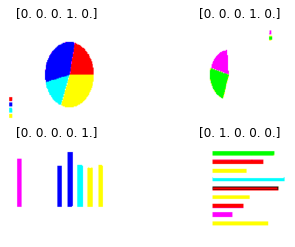

In [5]:
# checking/ validating some images generated by datagenerator

print ('indices of categories : {}'.format(train_data_gen.class_indices))

# This function will plot 4 images along with their labels.
def plotImages(image_datas,y_list):
    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(image_datas[0], cmap='gray')
    axarr[0,0].set_title(y_list[0])
    axarr[0,0].axis('off')
    axarr[0,1].imshow(image_datas[1], cmap='gray')
    axarr[0,1].set_title(y_list[1])
    axarr[0,1].axis('off')
    axarr[1,0].imshow(image_datas[2], cmap='gray')
    axarr[1,0].set_title(y_list[2])
    axarr[1,0].axis('off')
    axarr[1,1].imshow(image_datas[3], cmap='gray')
    axarr[1,1].set_title(y_list[3])
    axarr[1,1].axis('off')

sample_training_images, y_list = next(train_data_gen)
sample_training_images = np.squeeze(sample_training_images) # to reduce dimension
print("shape of a batch given by image data generator : {}".format(sample_training_images.shape))

plotImages(sample_training_images[:4],y_list[:4])

In [6]:
# loading VGG16 with weights trained on imagenet dataset and w/o top classification layers 
base_VGG16 = tf.keras.applications.VGG16(input_shape=IMAGE_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_VGG16.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

Training only top dense layers for predicting class

In [7]:
def create_VGG_based_model():
    
    base_VGG16.trainable = False # freezing the convulation layers of VGG16 by making them untrainable

    model = tf.keras.models.Sequential([
        base_VGG16,
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_OF_CLASSES, activation='softmax') 
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

    return model

In [8]:
VGG_based_model = create_VGG_based_model()
VGG_based_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 14,747,845
Trainable params: 33,157
Non-trainable params: 14,714,688
_________________________________________________________________


In [9]:
# training

VGG_based_model_checkpoint_filepath = 'VGG_based_model/checkpoint/'
VGG_based_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=VGG_based_model_checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=0, mode='auto')

VGG_based_model_history = VGG_based_model.fit(train_data_gen, epochs=50, 
                    validation_data=val_data_gen,
                    callbacks=[VGG_based_model_checkpoint_callback, early_stopping_callback])

Epoch 1/50
25/25 [==============================] - 7s 266ms/step - loss: 2.8332 - accuracy: 0.5487 - val_loss: 0.1477 - val_accuracy: 0.9300
Epoch 2/50
25/25 [==============================] - 6s 233ms/step - loss: 0.2750 - accuracy: 0.9000 - val_loss: 0.0330 - val_accuracy: 0.9950
Epoch 3/50
25/25 [==============================] - 6s 232ms/step - loss: 0.1252 - accuracy: 0.9575 - val_loss: 0.0197 - val_accuracy: 1.0000
Epoch 4/50
25/25 [==============================] - 6s 231ms/step - loss: 0.0803 - accuracy: 0.9750 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 5/50
25/25 [==============================] - 6s 232ms/step - loss: 0.0797 - accuracy: 0.9700 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 6/50
25/25 [==============================] - 6s 231ms/step - loss: 0.0576 - accuracy: 0.9775 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 7/50
25/25 [==============================] - 6s 229ms/step - loss: 0.0477 - accuracy: 0.9837 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 

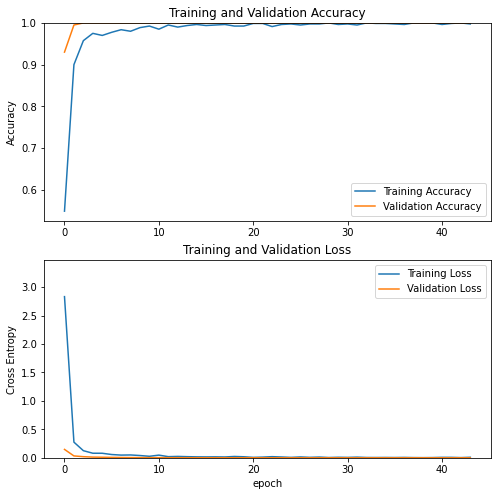

In [10]:
plot_loss_accuracy(VGG_based_model_history)

In [13]:
# loading best weights and saving the model for future use

VGG_based_model.load_weights(VGG_based_model_checkpoint_filepath)
VGG_based_model.evaluate(val_data_gen)

# saving the entire model to be used for testing
VGG_based_model.save("VGG_based_model.h5")


7/7 [==============================] - 1s 141ms/step - loss: 0.0197 - accuracy: 1.0000


### Observation :

Using Convulation Layers of VGG16 and training just the top dense layers for classification can get 100% validation accuracy